In [11]:
import collections
import datetime
import math
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [ ]:
initial_profits = pd.DataFrame([i for i in range(0, 29, 2)])
diff_profits = initial_profits.diff(7).to_numpy()
undiff = diff_profits.copy()
initial = initial_profits.to_numpy()

for i in range(len(diff_profits)):
    if np.isnan(undiff[i]):
        undiff[i] = initial[i]
    else:
        undiff[i] = undiff[i] + initial[i-7]
        
print(initial)
print(undiff)


In [56]:
schema = 'test'
data = [i for i in range(28)]
columns = ['PROFIT']
index = pd.date_range(start='1/05/2016', periods=28).tolist()
features = pd.DataFrame(data, columns=columns, index=index)

In [57]:
Models = collections.namedtuple('Models', ['MODEL', 'PARAMS'])
Model_Params = collections.namedtuple('Model_Params', ['LOSS', 'OPTIMIZER', 
                                      'EPOCHS', 'CALLBACKS', 'VERBOSE'])

In [60]:
class schema_ML():
    def __init__(self, schema, df):
        
        # Store initial data.
        self.schema = schema
        self.df_initial = df
        
        self.models = {}
        self.model_params = Model_Params('mae', 'adam', 500, [], 2)
        
        self.train_performance = {}
        self.test_performance = {}
        self.mfe = {}
        self.mae = {}
        self.mse = {}
        self.rmse = {}
        
        # Preprocess data.
        self.preprocess()
        
    def preprocess(self):
        
        # Reference DF
        df = self.df_initial
        
#         # Combine individual date columns to single index
#         df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
#         df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
#         df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
#         df.set_index('DATE', inplace=True)
        
        # Insert zeros for missing dates
        df = self.add_missing_dates(df)
        self.df = df
        df.plot(subplots=True, title='Initial Data') 
        
        # Add differencing
        df = self.add_differencing(df)
        self.differenced_df = df
        df.plot(subplots=True, title='Added Differencing')
        
        # Normalize using scaler
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled = scaler.fit_transform(df.values)
        df = pd.DataFrame(scaled, columns=df.columns)
        df.plot(subplots=True, title='Added Normalization')
        self.normalized_df = df
        self.scaler = scaler
        
        # Split into train/val/test
        train_df, test_df = self.train_test_split(df)
        
        self.train_df = train_df
        self.test_df = test_df
        
    def add_missing_dates(self, df):
        missing_dates = pd.date_range(start=df.index[0], end=df.index[-1]).difference(df.index)
        n = len(missing_dates)
        m = len(df.columns)
        missing_dates_data = np.zeros((n,m))
        missing_dates_df = pd.DataFrame(missing_dates_data, index=missing_dates, columns=df.columns)
        dfs = [df, missing_dates_df]
        df = pd.concat(dfs)
        df['Date'] = df.index
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        
        return df
        
    def add_differencing(self, df):
        diff = df.diff(7)
        
        return diff.dropna()
    
    def train_test_split(self, df):
        n = len(df)
        pct_test = (np.log2(n/2) * 0.01)
        num_test = int(n * pct_test)
        num_train = n - num_test
        
        train = df[:num_train]
        test = df[num_train:]
        
        return train, test
    
    def add_lag(self, df):
        lags = [1, 7, 14]
        cols = df.columns
        
        lagged = df.assign(**{
            '{} (t-{})'.format(col, t): df[col].shift(t)
            for t in lags
            for col in cols
        })
        
        return lagged.dropna()
    
    def reshape(self, X):
        X = X.values.reshape((X.shape[0], 1, X.shape[1]))
        
        return X
    
    def get_train_and_test(self, pred_col):
        train = self.train_df
        test = self.test_df

        train = self.add_lag(train)
        test = self.add_lag(test)

        X_train = train.filter(regex='^(?!' + pred_col + '$)')
        Y_train = train.filter(regex='^(' + pred_col + '$)')
        X_test = test.filter(regex='^(?!' + pred_col + '$)')
        Y_test = test.filter(regex='^(' + pred_col + '$)')
    
        X_train, X_test = self.reshape(X_train), self.reshape(X_test)
        
        return X_train, Y_train, X_test, Y_test
        
    def evaluate_and_plot(self, pred_col='PROFIT', model_name='', model=None, model_params=None):
        
        if model is not None:
        
            # Add model to dictionary
            if model_params == None:
                model_params = self.model_params

            if model is not None:
                self.models[model_name] = Models(model, model_params)

            # Get training and validation data
            X_train, Y_train, X_test, Y_test = self.get_train_and_test(pred_col)

            # Compile model    
            model.compile(loss=model_params.LOSS, optimizer=model_params.OPTIMIZER)
            
            # Fit model to training data
            history = model.fit(X_train, Y_train, epochs=model_params.EPOCHS, 
                                callbacks=model_params.CALLBACKS, validation_data=(X_test, Y_test),
                                verbose=model_params.VERBOSE, shuffle=False)

            # Add validation information to dictionary
            self.train_performance[model_name] = min(history.history['loss'])
            self.test_performance[model_name] = min(history.history['val_loss'])
            
            # Plot train vs. val losses
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='val')
            plt.title('Training Loss vs. Test Loss')
            plt.xlabel('# of Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
            # Calculate performance metrics and add to dictionaries
            expected = Y_test.values
            predicted = model(X_test)
            forecast_errors = [expected[i] - predicted[i] for i in range(len(expected))]
            
            mfe = np.mean(forecast_errors)
            mae = mean_absolute_error(expected, predicted)
            mse = mean_squared_error(expected, predicted)
            rmse = np.sqrt(mse)
            
            self.mfe[model_name] = mfe
            self.mae[model_name] = mae
            self.mse[model_name] = mse
            self.rmse[model_name] = rmse
            
            # Plot expected vs predicted
            plt.figure(figsize=(40,8))
            diff = self.test_df.index.shape[0] - expected.shape[0]
            plt.plot(self.test_df.index[diff:], expected, label='Expected', marker='.', zorder=-10)
            plt.scatter(self.test_df.index[diff:], predicted, label='Predicted', edgecolors='k', c='#2ca02c', s=64)
            plt.show()
            
            ### TEST - Inverse transform scaler ###
            
#             scaler = self.scaler
#             df_one = self.train_df
#             df_three = self.test_df
#             expected_df = pd.DataFrame(expected, index=Y_test.index, columns=Y_test.columns)
#             predicted_df = pd.DataFrame(predicted.numpy(), index=Y_test.index, columns=Y_test.columns)
            
#             expected_frames = [df_one[['PROFIT', 'CES']], expected_df, df_three[['PROFIT', 'CES']]]
#             predicted_frames = [df_one[['PROFIT', 'CES']], predicted_df, df_three[['PROFIT', 'CES']]]
#             full_expected_df = pd.concat(expected_frames)
#             full_predicted_df = pd.concat(predicted_frames)
            
#             inverse_expected = scaler.inverse_transform(full_expected_df)
#             inverse_predicted = scaler.inverse_transform(full_predicted_df)
            
#             indexes = df_one.index.union(expected_df.index).union(df_three.index)      
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=indexes)
#             print(inverse_expected_df)
            
            
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=self.df_initial.index, columns=['PROFIT', 'CES'])
#             inverse_predicted_df = pd.DataFrame(inverse_predicted, index=self.df_initial.index, columns=['PROFIT', 'CES'])
            
            ### END TEST ###
            
            
        # Plot specified columns and results
        
        
    def performance_metrics(self):
        
        # Convert dictionarites to single dataframe
        mfe_df = pd.DataFrame.from_dict(self.mfe, columns=['MFE'], orient='index')
        mae_df = pd.DataFrame.from_dict(self.mae, columns=['MAE'], orient='index')
        mse_df = pd.DataFrame.from_dict(self.mse, columns=['MSE'], orient='index')
        rmse_df = pd.DataFrame.from_dict(self.rmse, columns=['RMSE'], orient='index')
        performance_df = mfe_df.join(mae_df).join(mse_df).join(rmse_df)
        performance_df = performance_df.transpose()
        
        performance_df.plot(kind='bar')
        plt.show()
        print(performance_df)

        

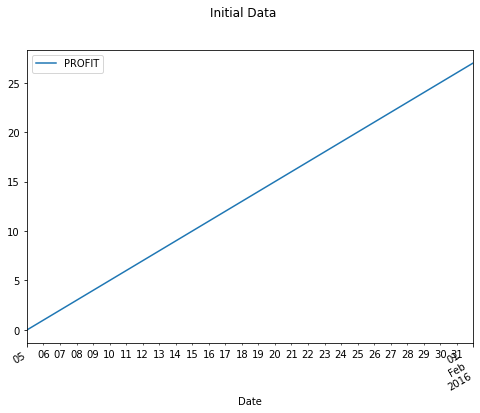

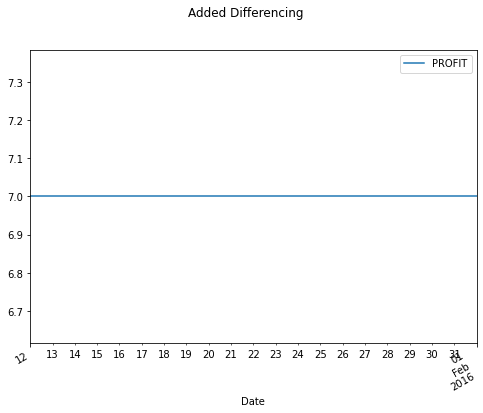

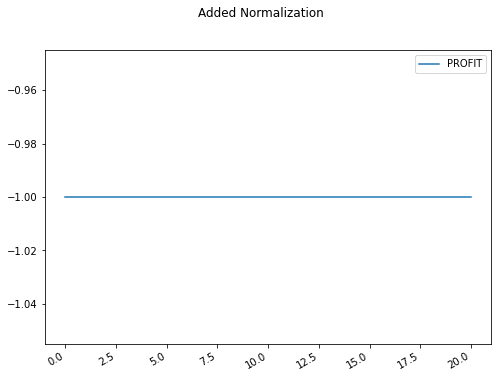

In [61]:
obj = schema_ML(schema, features)

In [62]:
MONITOR = 'val_loss'
PATIENCE = 5
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'Base LSTM'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)

Epoch 1/500
1/1 - 2s - loss: 0.9424
Epoch 2/500
1/1 - 0s - loss: 0.9285
Epoch 3/500
1/1 - 0s - loss: 0.9147
Epoch 4/500
1/1 - 0s - loss: 0.9008
Epoch 5/500
1/1 - 0s - loss: 0.8870
Epoch 6/500
1/1 - 0s - loss: 0.8731
Epoch 7/500
1/1 - 0s - loss: 0.8592
Epoch 8/500
1/1 - 0s - loss: 0.8454
Epoch 9/500
1/1 - 0s - loss: 0.8315
Epoch 10/500
1/1 - 0s - loss: 0.8175
Epoch 11/500
1/1 - 0s - loss: 0.8036
Epoch 12/500
1/1 - 0s - loss: 0.7896
Epoch 13/500
1/1 - 0s - loss: 0.7756
Epoch 14/500
1/1 - 0s - loss: 0.7616
Epoch 15/500
1/1 - 0s - loss: 0.7475
Epoch 16/500
1/1 - 0s - loss: 0.7333
Epoch 17/500
1/1 - 0s - loss: 0.7191
Epoch 18/500
1/1 - 0s - loss: 0.7048
Epoch 19/500
1/1 - 0s - loss: 0.6904
Epoch 20/500
1/1 - 0s - loss: 0.6759
Epoch 21/500
1/1 - 0s - loss: 0.6613
Epoch 22/500
1/1 - 0s - loss: 0.6465
Epoch 23/500
1/1 - 0s - loss: 0.6317
Epoch 24/500
1/1 - 0s - loss: 0.6167
Epoch 25/500
1/1 - 0s - loss: 0.6016
Epoch 26/500
1/1 - 0s - loss: 0.5863
Epoch 27/500
1/1 - 0s - loss: 0.5709
Epoch 28/5

Epoch 54/500
1/1 - 0s - loss: 0.0668
Epoch 55/500
1/1 - 0s - loss: 0.0440
Epoch 56/500
1/1 - 0s - loss: 0.0209
Epoch 57/500
1/1 - 0s - loss: 0.0025
Epoch 58/500
1/1 - 0s - loss: 0.0210
Epoch 59/500
1/1 - 0s - loss: 0.0349
Epoch 60/500
1/1 - 0s - loss: 0.0447
Epoch 61/500
1/1 - 0s - loss: 0.0509
Epoch 62/500
1/1 - 0s - loss: 0.0537
Epoch 63/500
1/1 - 0s - loss: 0.0536
Epoch 64/500
1/1 - 0s - loss: 0.0509
Epoch 65/500
1/1 - 0s - loss: 0.0459
Epoch 66/500
1/1 - 0s - loss: 0.0389
Epoch 67/500
1/1 - 0s - loss: 0.0302
Epoch 68/500
1/1 - 0s - loss: 0.0199
Epoch 69/500
1/1 - 0s - loss: 0.0084
Epoch 70/500
1/1 - 0s - loss: 0.0043
Epoch 71/500
1/1 - 0s - loss: 0.0133
Epoch 72/500
1/1 - 0s - loss: 0.0189
Epoch 73/500
1/1 - 0s - loss: 0.0217
Epoch 74/500
1/1 - 0s - loss: 0.0218
Epoch 75/500
1/1 - 0s - loss: 0.0197
Epoch 76/500
1/1 - 0s - loss: 0.0155
Epoch 77/500
1/1 - 0s - loss: 0.0094
Epoch 78/500
1/1 - 0s - loss: 0.0016
Epoch 79/500
1/1 - 0s - loss: 0.0077
Epoch 80/500
1/1 - 0s - loss: 0.0138
E

Epoch 107/500
1/1 - 0s - loss: 0.0015
Epoch 108/500
1/1 - 0s - loss: 0.0011
Epoch 109/500
1/1 - 0s - loss: 0.0012
Epoch 110/500
1/1 - 0s - loss: 9.2518e-04
Epoch 111/500
1/1 - 0s - loss: 6.2764e-04
Epoch 112/500
1/1 - 0s - loss: 0.0018
Epoch 113/500
1/1 - 0s - loss: 0.0018
Epoch 114/500
1/1 - 0s - loss: 3.0398e-04
Epoch 115/500
1/1 - 0s - loss: 6.4748e-05
Epoch 116/500
1/1 - 0s - loss: 0.0023
Epoch 117/500
1/1 - 0s - loss: 0.0023
Epoch 118/500
1/1 - 0s - loss: 1.1802e-04
Epoch 119/500
1/1 - 0s - loss: 0.0040
Epoch 120/500
1/1 - 0s - loss: 0.0055
Epoch 121/500
1/1 - 0s - loss: 0.0048
Epoch 122/500
1/1 - 0s - loss: 0.0019
Epoch 123/500
1/1 - 0s - loss: 0.0028
Epoch 124/500
1/1 - 0s - loss: 0.0049
Epoch 125/500
1/1 - 0s - loss: 0.0046
Epoch 126/500
1/1 - 0s - loss: 0.0023
Epoch 127/500
1/1 - 0s - loss: 0.0020
Epoch 128/500
1/1 - 0s - loss: 0.0037
Epoch 129/500
1/1 - 0s - loss: 0.0031
Epoch 130/500
1/1 - 0s - loss: 3.8540e-04
Epoch 131/500
1/1 - 0s - loss: 0.0042
Epoch 132/500
1/1 - 0s - l

Epoch 159/500
1/1 - 0s - loss: 0.0031
Epoch 160/500
1/1 - 0s - loss: 0.0052
Epoch 161/500
1/1 - 0s - loss: 0.0050
Epoch 162/500
1/1 - 0s - loss: 0.0027
Epoch 163/500
1/1 - 0s - loss: 0.0015
Epoch 164/500
1/1 - 0s - loss: 0.0031
Epoch 165/500
1/1 - 0s - loss: 0.0025
Epoch 166/500
1/1 - 0s - loss: 1.8108e-04
Epoch 167/500
1/1 - 0s - loss: 4.8035e-04
Epoch 168/500
1/1 - 0s - loss: 0.0013
Epoch 169/500
1/1 - 0s - loss: 8.8811e-04
Epoch 170/500
1/1 - 0s - loss: 0.0016
Epoch 171/500
1/1 - 0s - loss: 0.0018
Epoch 172/500
1/1 - 0s - loss: 1.7297e-04
Epoch 173/500
1/1 - 0s - loss: 1.6642e-04
Epoch 174/500
1/1 - 0s - loss: 0.0016
Epoch 175/500
1/1 - 0s - loss: 0.0011
Epoch 176/500
1/1 - 0s - loss: 0.0014
Epoch 177/500
1/1 - 0s - loss: 0.0016
Epoch 178/500
1/1 - 0s - loss: 3.3462e-04
Epoch 179/500
1/1 - 0s - loss: 2.5868e-05
Epoch 180/500
1/1 - 0s - loss: 0.0017
Epoch 181/500
1/1 - 0s - loss: 0.0012
Epoch 182/500
1/1 - 0s - loss: 0.0013
Epoch 183/500
1/1 - 0s - loss: 0.0015
Epoch 184/500
1/1 - 0s

Epoch 211/500
1/1 - 0s - loss: 0.0035
Epoch 212/500
1/1 - 0s - loss: 0.0056
Epoch 213/500
1/1 - 0s - loss: 0.0054
Epoch 214/500
1/1 - 0s - loss: 0.0032
Epoch 215/500
1/1 - 0s - loss: 8.0633e-04
Epoch 216/500
1/1 - 0s - loss: 0.0024
Epoch 217/500
1/1 - 0s - loss: 0.0017
Epoch 218/500
1/1 - 0s - loss: 8.9097e-04
Epoch 219/500
1/1 - 0s - loss: 0.0012
Epoch 220/500
1/1 - 0s - loss: 5.6767e-04
Epoch 221/500
1/1 - 0s - loss: 1.0572e-04
Epoch 222/500
1/1 - 0s - loss: 0.0024
Epoch 223/500
1/1 - 0s - loss: 0.0025
Epoch 224/500
1/1 - 0s - loss: 6.3694e-04
Epoch 225/500
1/1 - 0s - loss: 0.0031
Epoch 226/500
1/1 - 0s - loss: 0.0045
Epoch 227/500
1/1 - 0s - loss: 0.0036
Epoch 228/500
1/1 - 0s - loss: 7.6330e-04
Epoch 229/500
1/1 - 0s - loss: 0.0038
Epoch 230/500
1/1 - 0s - loss: 0.0059
Epoch 231/500
1/1 - 0s - loss: 0.0058
Epoch 232/500
1/1 - 0s - loss: 0.0036
Epoch 233/500
1/1 - 0s - loss: 4.5455e-04
Epoch 234/500
1/1 - 0s - loss: 0.0020
Epoch 235/500
1/1 - 0s - loss: 0.0014
Epoch 236/500
1/1 - 0s

Epoch 263/500
1/1 - 0s - loss: 0.0037
Epoch 264/500
1/1 - 0s - loss: 0.0059
Epoch 265/500
1/1 - 0s - loss: 0.0058
Epoch 266/500
1/1 - 0s - loss: 0.0037
Epoch 267/500
1/1 - 0s - loss: 2.5845e-04
Epoch 268/500
1/1 - 0s - loss: 0.0018
Epoch 269/500
1/1 - 0s - loss: 0.0011
Epoch 270/500
1/1 - 0s - loss: 0.0016
Epoch 271/500
1/1 - 0s - loss: 0.0019
Epoch 272/500
1/1 - 0s - loss: 2.0194e-04
Epoch 273/500
1/1 - 0s - loss: 0.0034
Epoch 274/500
1/1 - 0s - loss: 0.0046
Epoch 275/500
1/1 - 0s - loss: 0.0036
Epoch 276/500
1/1 - 0s - loss: 6.7997e-04
Epoch 277/500
1/1 - 0s - loss: 0.0040
Epoch 278/500
1/1 - 0s - loss: 0.0061
Epoch 279/500
1/1 - 0s - loss: 0.0060
Epoch 280/500
1/1 - 0s - loss: 0.0039
Epoch 281/500
1/1 - 0s - loss: 2.0623e-05
Epoch 282/500
1/1 - 0s - loss: 0.0056
Epoch 283/500
1/1 - 0s - loss: 0.0085
Epoch 284/500
1/1 - 0s - loss: 0.0092
Epoch 285/500
1/1 - 0s - loss: 0.0077
Epoch 286/500
1/1 - 0s - loss: 0.0043
Epoch 287/500
1/1 - 0s - loss: 7.4410e-04
Epoch 288/500
1/1 - 0s - loss:

Epoch 315/500
1/1 - 0s - loss: 0.0069
Epoch 316/500
1/1 - 0s - loss: 0.0036
Epoch 317/500
1/1 - 0s - loss: 0.0015
Epoch 318/500
1/1 - 0s - loss: 0.0040
Epoch 319/500
1/1 - 0s - loss: 0.0042
Epoch 320/500
1/1 - 0s - loss: 0.0024
Epoch 321/500
1/1 - 0s - loss: 0.0012
Epoch 322/500
1/1 - 0s - loss: 0.0025
Epoch 323/500
1/1 - 0s - loss: 0.0016
Epoch 324/500
1/1 - 0s - loss: 0.0013
Epoch 325/500
1/1 - 0s - loss: 0.0018
Epoch 326/500
1/1 - 0s - loss: 2.4880e-04
Epoch 327/500
1/1 - 0s - loss: 0.0032
Epoch 328/500
1/1 - 0s - loss: 0.0042
Epoch 329/500
1/1 - 0s - loss: 0.0031
Epoch 330/500
1/1 - 0s - loss: 1.3076e-04
Epoch 331/500
1/1 - 0s - loss: 0.0046
Epoch 332/500
1/1 - 0s - loss: 0.0068
Epoch 333/500
1/1 - 0s - loss: 0.0068
Epoch 334/500
1/1 - 0s - loss: 0.0048
Epoch 335/500
1/1 - 0s - loss: 9.5195e-04
Epoch 336/500
1/1 - 0s - loss: 0.0045
Epoch 337/500
1/1 - 0s - loss: 0.0074
Epoch 338/500
1/1 - 0s - loss: 0.0080
Epoch 339/500
1/1 - 0s - loss: 0.0065
Epoch 340/500
1/1 - 0s - loss: 0.0031


Epoch 367/500
1/1 - 0s - loss: 0.0021
Epoch 368/500
1/1 - 0s - loss: 8.8292e-04
Epoch 369/500
1/1 - 0s - loss: 0.0015
Epoch 370/500
1/1 - 0s - loss: 1.2481e-04
Epoch 371/500
1/1 - 0s - loss: 0.0032
Epoch 372/500
1/1 - 0s - loss: 0.0041
Epoch 373/500
1/1 - 0s - loss: 0.0029
Epoch 374/500
1/1 - 0s - loss: 1.2189e-04
Epoch 375/500
1/1 - 0s - loss: 8.6749e-04
Epoch 376/500
1/1 - 0s - loss: 4.7350e-04
Epoch 377/500
1/1 - 0s - loss: 3.3288e-04
Epoch 378/500
1/1 - 0s - loss: 9.5391e-04
Epoch 379/500
1/1 - 0s - loss: 9.8586e-05
Epoch 380/500
1/1 - 0s - loss: 0.0027
Epoch 381/500
1/1 - 0s - loss: 0.0032
Epoch 382/500
1/1 - 0s - loss: 0.0016
Epoch 383/500
1/1 - 0s - loss: 0.0018
Epoch 384/500
1/1 - 0s - loss: 0.0029
Epoch 385/500
1/1 - 0s - loss: 0.0018
Epoch 386/500
1/1 - 0s - loss: 0.0011
Epoch 387/500
1/1 - 0s - loss: 0.0018
Epoch 388/500
1/1 - 0s - loss: 3.8862e-04
Epoch 389/500
1/1 - 0s - loss: 0.0029
Epoch 390/500
1/1 - 0s - loss: 0.0038
Epoch 391/500
1/1 - 0s - loss: 0.0027
Epoch 392/500


Epoch 419/500
1/1 - 0s - loss: 1.8367e-05
Epoch 420/500
1/1 - 0s - loss: 0.0012
Epoch 421/500
1/1 - 0s - loss: 2.5392e-04
Epoch 422/500
1/1 - 0s - loss: 0.0026
Epoch 423/500
1/1 - 0s - loss: 0.0031
Epoch 424/500
1/1 - 0s - loss: 0.0016
Epoch 425/500
1/1 - 0s - loss: 0.0017
Epoch 426/500
1/1 - 0s - loss: 0.0027
Epoch 427/500
1/1 - 0s - loss: 0.0016
Epoch 428/500
1/1 - 0s - loss: 0.0013
Epoch 429/500
1/1 - 0s - loss: 0.0020
Epoch 430/500
1/1 - 0s - loss: 6.4426e-04
Epoch 431/500
1/1 - 0s - loss: 0.0026
Epoch 432/500
1/1 - 0s - loss: 0.0035
Epoch 433/500
1/1 - 0s - loss: 0.0023
Epoch 434/500
1/1 - 0s - loss: 7.2467e-04
Epoch 435/500
1/1 - 0s - loss: 0.0015
Epoch 436/500
1/1 - 0s - loss: 1.6213e-04
Epoch 437/500
1/1 - 0s - loss: 0.0030
Epoch 438/500
1/1 - 0s - loss: 0.0039
Epoch 439/500
1/1 - 0s - loss: 0.0027
Epoch 440/500
1/1 - 0s - loss: 4.4055e-04
Epoch 441/500
1/1 - 0s - loss: 0.0012
Epoch 442/500
1/1 - 0s - loss: 4.9949e-05
Epoch 443/500
1/1 - 0s - loss: 7.9602e-04
Epoch 444/500
1/1 

Epoch 471/500
1/1 - 0s - loss: 0.0029
Epoch 472/500
1/1 - 0s - loss: 0.0037
Epoch 473/500
1/1 - 0s - loss: 0.0025
Epoch 474/500
1/1 - 0s - loss: 6.7550e-04
Epoch 475/500
1/1 - 0s - loss: 0.0015
Epoch 476/500
1/1 - 0s - loss: 2.2632e-04
Epoch 477/500
1/1 - 0s - loss: 0.0029
Epoch 478/500
1/1 - 0s - loss: 0.0037
Epoch 479/500
1/1 - 0s - loss: 0.0025
Epoch 480/500
1/1 - 0s - loss: 6.6822e-04
Epoch 481/500
1/1 - 0s - loss: 0.0015
Epoch 482/500
1/1 - 0s - loss: 2.3818e-04
Epoch 483/500
1/1 - 0s - loss: 0.0029
Epoch 484/500
1/1 - 0s - loss: 0.0037
Epoch 485/500
1/1 - 0s - loss: 0.0024
Epoch 486/500
1/1 - 0s - loss: 7.0781e-04
Epoch 487/500
1/1 - 0s - loss: 0.0015
Epoch 488/500
1/1 - 0s - loss: 2.8825e-04
Epoch 489/500
1/1 - 0s - loss: 0.0028
Epoch 490/500
1/1 - 0s - loss: 0.0036
Epoch 491/500
1/1 - 0s - loss: 0.0024
Epoch 492/500
1/1 - 0s - loss: 7.7242e-04
Epoch 493/500
1/1 - 0s - loss: 0.0016
Epoch 494/500
1/1 - 0s - loss: 3.5829e-04
Epoch 495/500
1/1 - 0s - loss: 0.0028
Epoch 496/500
1/1 

KeyError: 'val_loss'